In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun May 31 08:15:49 2020

@author: sedna
"""

from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.engine import Model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import tensorflow as tf

import os
import sys
import tarfile

import matplotlib.pyplot as plt
import numpy as np
from keras.utils.data_utils import get_file

#if sys.version_info >= (3, 0, 0):
import urllib.request as urllib  # ugly but works
#else:
#import urllib

#print(sys.version_info)
PATHG='/kaggle/working/'
# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = 'stl10_binary'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'


In [62]:
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


In [63]:
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images



In [64]:
def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


In [65]:

def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()


def load_data():
    # download data if needed
    path = get_file(DATA_DIR, origin=DATA_URL, untar=True)

    # test to check if the whole dataset is read correctly
    # path to the binary train file with image data
    train_data_path = os.path.join(path, 'train_X.bin')

    # path to the binary train file with labels
    train_label_path = os.path.join(path, 'train_y.bin')

    # path to the binary test file with image data
    test_data_path = os.path.join(path, 'test_X.bin')

    # path to the binary test file with labels
    test_label_path = os.path.join(path, 'test_y.bin')

    x_train = read_all_images(train_data_path)
    print(x_train.shape)

    y_train = read_labels(train_label_path)
    print(y_train.shape)

    x_test = read_all_images(test_data_path)
    print(x_test.shape)

    y_test = read_labels(test_label_path)
    print(y_test.shape)

    return (x_train, y_train), (x_test, y_test)

In [66]:
img_width, img_height = 96, 96
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

nb_train_samples = 5000
nb_validation_samples = 8000
nb_epoch = 50
nb_classes = 10

In [67]:

(X_train, y_train), (X_test, y_test) = load_data()
X_train.shape

Y_train = np_utils.to_categorical(y_train - 1, nb_classes)
Y_test = np_utils.to_categorical(y_test - 1, nb_classes)


(5000, 96, 96, 3)
(5000,)
(8000, 96, 96, 3)
(8000,)


In [68]:
n_layers=-3
last = base_model.output
x = Flatten()(last)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
pred = Dense(10, activation='sigmoid')(x)

model = Model(base_model.input, pred)

for layer in base_model.layers[:n_layers]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in base_model.layers:
             print(layer, layer.trainable)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])

model.summary()

<keras.engine.input_layer.InputLayer object at 0x7fe38db6e950> False
<keras.layers.convolutional.Conv2D object at 0x7fe38db6e750> False
<keras.layers.convolutional.Conv2D object at 0x7fe38db6e050> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe38db6ea50> False
<keras.layers.convolutional.Conv2D object at 0x7fe38d7e5e50> False
<keras.layers.convolutional.Conv2D object at 0x7fe38d6044d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe38dc14e90> False
<keras.layers.convolutional.Conv2D object at 0x7fe38dc10110> False
<keras.layers.convolutional.Conv2D object at 0x7fe38db58890> False
<keras.layers.convolutional.Conv2D object at 0x7fe38db53f90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe38db53050> False
<keras.layers.convolutional.Conv2D object at 0x7fe38db55bd0> False
<keras.layers.convolutional.Conv2D object at 0x7fe38d9aa150> False
<keras.layers.convolutional.Conv2D object at 0x7fe38d87fdd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe38d87f490>

In [104]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32, shuffle=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow(X_test, Y_test, batch_size=32,shuffle=False)

In [70]:

from keras.callbacks import EarlyStopping
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.005,verbose=1)


In [71]:
history=model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    nb_epoch=nb_epoch,
    callbacks=[es],
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., callbacks=[<keras.ca..., validation_data=<keras.pre..., steps_per_epoch=156, epochs=50, validation_steps=8000)`
  import sys


Epoch 1/50
156/156 [==============================] - 162s 1s/step - loss: 0.6520 - accuracy: 0.5439 - val_loss: 0.5977 - val_accuracy: 0.6548
Epoch 2/50
156/156 [==============================] - 163s 1s/step - loss: 0.5563 - accuracy: 0.7425 - val_loss: 0.5161 - val_accuracy: 0.8026
Epoch 3/50
156/156 [==============================] - 163s 1s/step - loss: 0.4953 - accuracy: 0.8473 - val_loss: 0.4879 - val_accuracy: 0.8675
Epoch 4/50
156/156 [==============================] - 162s 1s/step - loss: 0.4530 - accuracy: 0.8838 - val_loss: 0.4501 - val_accuracy: 0.8909
Epoch 5/50
156/156 [==============================] - 162s 1s/step - loss: 0.4221 - accuracy: 0.8959 - val_loss: 0.4087 - val_accuracy: 0.8979
Epoch 6/50
156/156 [==============================] - 163s 1s/step - loss: 0.3985 - accuracy: 0.8988 - val_loss: 0.3977 - val_accuracy: 0.8994
Epoch 7/50
156/156 [==============================] - 163s 1s/step - loss: 0.3809 - accuracy: 0.8997 - val_loss: 0.3713 - val_accuracy: 0.8998

In [72]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


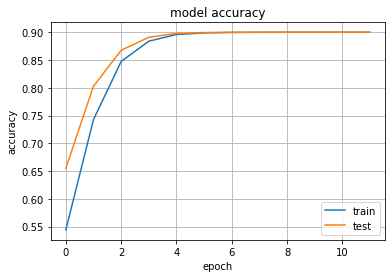

In [73]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid(True)
plt.show()

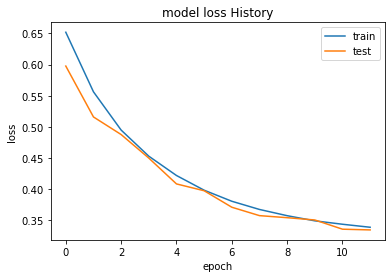

In [74]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [75]:
#MODEL EVALUATION

score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

8000/8000 [==============================] - 5s 626us/step
Test score: 252.69670734405517
Test accuracy: 73.96748661994934


In [111]:
batch_size=32
validation_generator.reset()
pred = model.predict_generator(validation_generator, steps=len(validation_generator), verbose=2)

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import pandas as pd

y_pred = np.argmax(pred, axis=1)

x_gen,y_gen =validation_generator.next()
print(y_gen.shape)
y_gen = np.argmax(y_gen, axis=1)

print('Confusion Matrix')
#print(pd.DataFrame(confusion_matrix(y_gen, y_pred)))
[y_gen.shape, y_pred.shape]

(32, 10)
Confusion Matrix


[(32,), (8000,)]

In [115]:
batch_size=32
pred= model.predict_generator(validation_generator, nb_validation_samples // batch_size)
predicted_class_indices=np.argmax(pred,axis=1)

predictions = [y_test[k] for k in predicted_class_indices]
print(len(predicted_class_indices))

print (len(predictions))

8000
8000


0


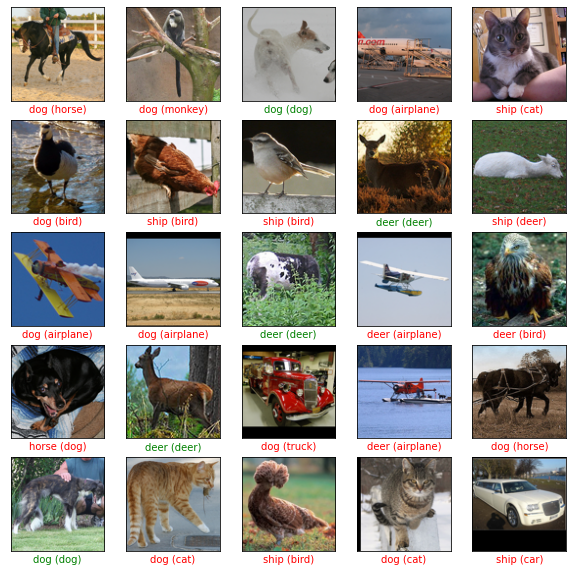

<Figure size 432x288 with 0 Axes>

In [123]:
#MODEL PREDICTION
class_names=["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
#predictions = model.predict(X_test)
#predicted_labels=model.predict_classes(X_test)
#print([predictions[0],predicted_labels[0]])
batch_size=32
pred= model.predict_generator(validation_generator, nb_validation_samples // batch_size)
predicted_class_indices=np.argmax(pred,axis=1)

#predicted_label = [y_test[k] for k in predicted_class_indices]
#print(len(predicted_class_indices))

#max= np.argmax(predictions[0])
#print(max)

#tt=y_test[0]
#print(tt)

# Plot the first 25 test images, their predicted label, and the true label
# Color correct predictions in green, incorrect predictions in red
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('False')
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    #plt.imshow(X_test[i], interpolation='nearest')
    #predicted_label = np.argmax(predictions[i])
    predicted_label=predicted_class_indices[i]
    true_label = y_test[i]
    if predicted_label == true_label:
      color = 'green'
    else:
      color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label-1], 
                                  class_names[true_label-1]),
                                  color=color)
plt.show()
plt.savefig(PATHG+ "stl10.pdf")


In [127]:
predictions=model.predict(X_test)
countv=0
for i in range(8000):
    predicted_label=predicted_class_indices[i]
    #predicted_label=np.argmax(predictions[i])
    true_label = y_test[i]
    if predicted_label == true_label:
         countv+=1
print("Performance:",countv/80)

Performance: 13.075


In [131]:
val_loss,val_accuracy=model.evaluate_generator(validation_generator,nb_validation_samples // batch_size)
[val_loss, val_accuracy]

In [77]:
print('Finish')

Finish


In [ ]:
# Create a generator for prediction

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
# Get the filenames from the generator
fnames = validation_generator.filenames
# Get the ground truth from generator

ground_truth = validation_generator.classes
# Get the label to class mapping from the generator

label2index = validation_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]

print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors

for i in range(len(errors)):

    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],

        pred_label,

        predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))

    plt.figure(figsize=[7,7])

    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
